# Vegetable Image Classification using CNN
## Deep Learning Project

### Project Overview
This project builds a Convolutional Neural Network (CNN) to classify images of 15 different vegetables.

**Dataset**: 15,000 training images, 3,000 validation images, 3,000 test images across 15 vegetable classes

## 1. Data Collection

In [49]:
# Install kagglehub if not already installed
!pip install kagglehub -q

In [50]:
# Download the Vegetable Image Dataset from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vegetable-image-dataset' dataset.
Path to dataset files: /kaggle/input/vegetable-image-dataset


In [51]:
# List the contents of the downloaded dataset
import os

dataset_path = path
print("Dataset contents:")
for item in os.listdir(dataset_path):
    print(f"  - {item}")

Dataset contents:
  - Vegetable Images


In [52]:
# Set up paths for train, validation, and test datasets
train_path = os.path.join(dataset_path, 'Vegetable Images', 'train')
validation_path = os.path.join(dataset_path, 'Vegetable Images', 'validation')
test_path = os.path.join(dataset_path, 'Vegetable Images', 'test')

print(f"Train path: {train_path}")
print(f"Validation path: {validation_path}")
print(f"Test path: {test_path}")

Train path: /kaggle/input/vegetable-image-dataset/Vegetable Images/train
Validation path: /kaggle/input/vegetable-image-dataset/Vegetable Images/validation
Test path: /kaggle/input/vegetable-image-dataset/Vegetable Images/test


In [53]:
# Count images in each dataset
def count_images(path):
    total = 0
    classes = 0
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            classes += 1
            num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
            total += num_images
    return total, classes

train_count, train_classes = count_images(train_path)
val_count, val_classes = count_images(validation_path)
test_count, test_classes = count_images(test_path)

print(f"Found {train_count} images belonging to {train_classes} classes.")
print(f"Found {val_count} images belonging to {val_classes} classes.")
print(f"Found {test_count} images belonging to {test_classes} classes.")

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## 2. Data Analysis and Visualization

In [54]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

In [55]:
# Get list of all vegetable categories
image_categories = os.listdir(train_path)
print(f"Vegetable categories ({len(image_categories)}):")
for i, cat in enumerate(image_categories, 1):
    print(f"{i}. {cat}")

Vegetable categories (15):
1. Broccoli
2. Capsicum
3. Bottle_Gourd
4. Radish
5. Tomato
6. Brinjal
7. Pumpkin
8. Carrot
9. Papaya
10. Cabbage
11. Bitter_Gourd
12. Cauliflower
13. Bean
14. Cucumber
15. Potato


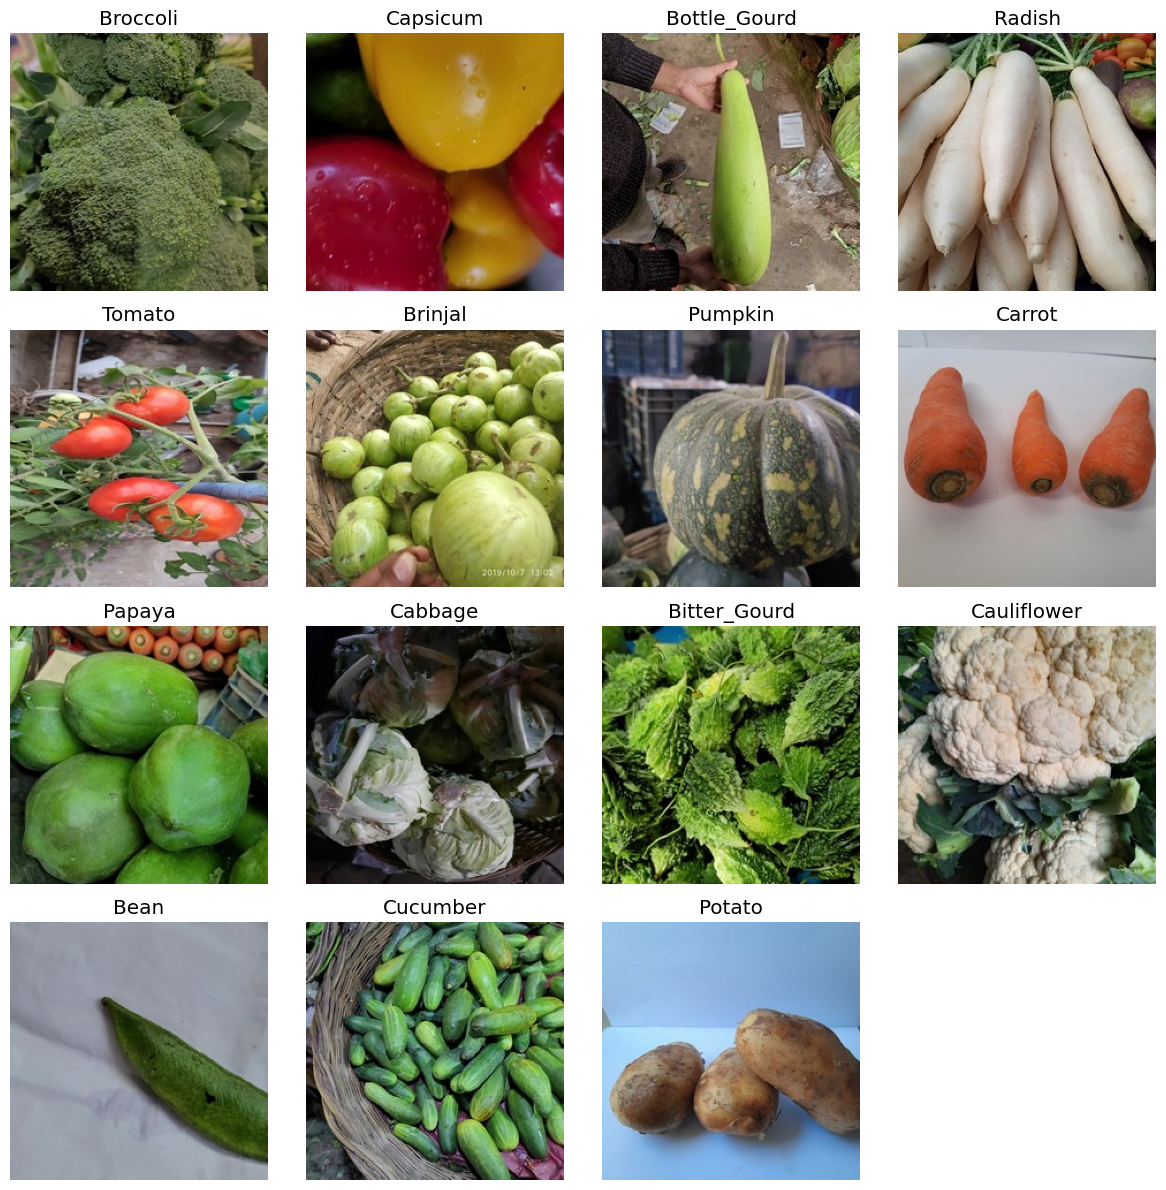

In [56]:
# Visualize sample images from each category
def plot_images(image_categories):
    # Create a figure
    plt.figure(figsize=(12, 12))

    for i, cat in enumerate(image_categories):
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = load_img(first_image_path)
        img_arr = img_to_array(img) / 255.0

        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Let's plot a few images
plot_images(image_categories)

## 3. Data Preprocessing

In [57]:
# Import required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
# Configure ImageDataGenerator class for data augmentation and normalization
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# For validation and test, only rescaling is needed
val_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [59]:
# Apply ImageDataGenerator functionality to Train, Validation and Test set
batch_size = 32
img_height = 150
img_width = 150

train_image_generator = train_image_generator.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_image_generator = val_image_generator.flow_from_directory(
    validation_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_image_generator = test_image_generator.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [60]:
# Print the class encodings done by the generators
class_map = dict((v, k) for k, v in train_image_generator.class_indices.items())
print("Class Map:")
for key, value in class_map.items():
    print(f"{key}: '{value}'")

Class Map:
0: 'Bean'
1: 'Bitter_Gourd'
2: 'Bottle_Gourd'
3: 'Brinjal'
4: 'Broccoli'
5: 'Cabbage'
6: 'Capsicum'
7: 'Carrot'
8: 'Cauliflower'
9: 'Cucumber'
10: 'Papaya'
11: 'Potato'
12: 'Pumpkin'
13: 'Radish'
14: 'Tomato'


## 4. Model Building

In [61]:
# Import necessary libraries for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [62]:
# Build the CNN model
model = Sequential()

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,252,815 (42.93 MB)

 Trainable params: 11,252,815 (42.93 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

In [63]:
# Import callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Compile and fit the model
early_stopping = EarlyStopping(patience=5)  # Set up callbacks

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(
    train_image_generator,
    epochs=100,
    verbose=1,
    validation_data=val_image_generator,
    steps_per_epoch=15000//32,
    validation_steps=3000//32,
    callbacks=[early_stopping]
)

Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 106s 219ms/step - accuracy: 0.2812 - loss: 2.1205 - val_accuracy: 0.6562 - val_loss: 1.0585
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5312 - loss: 1.5074 - val_accuracy: 0.6455 - val_loss: 1.0887
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 100s 214ms/step - accuracy: 0.6060 - loss: 1.1619 - val_accuracy: 0.7702 - val_loss: 0.7022
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5312 - loss: 1.0584 - val_accuracy: 0.7772 - val_loss: 0.6938
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 100s 214ms/step - accuracy: 0.7057 - loss: 0.8795 - val_accuracy: 0.8243 - val_loss: 0.5700
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8125 - loss: 0.6126 - val_accuracy: 0.8269 - val_loss: 0.5550
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 137s 213ms/step - accuracy: 0.7705 - loss: 0.7031 - val_accuracy: 0.8827 - val_loss: 0.4028
Epoch 8/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8750 - loss: 

## 6. Training Visualization

In [ ]:
# Plot the error and accuracy
h = hist.history

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))

plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')

plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

## 7. Model Evaluation

In [ ]:
# Predict the accuracy for the test set
test_loss, test_accuracy = model.evaluate(test_image_generator)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## 8. Testing the Model with Sample Images

In [ ]:
# Function to generate predictions
def generate_predictions(test_image_path, actual_label):
    # 1. Load and preprocess the image
    test_img = tf.keras.utils.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = tf.keras.utils.img_to_array(test_img) / 255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]

    # 3. Display the prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title(f"Predicted Label: {predicted_vegetable}, Actual Label: {actual_label}")
    plt.grid()
    plt.axis('off')
    plt.show()

    return predicted_vegetable

In [ ]:
# Test with sample images from different classes
# Example: Test with Broccoli
test_image_path = os.path.join(test_path, 'Broccoli', os.listdir(os.path.join(test_path, 'Broccoli'))[0])
prediction = generate_predictions(test_image_path, actual_label='Broccoli')

In [ ]:
# Test with more samples
# Potato
test_image_path = os.path.join(test_path, 'Potato', os.listdir(os.path.join(test_path, 'Potato'))[0])
prediction = generate_predictions(test_image_path, actual_label='Potato')

In [ ]:
# Radish
test_image_path = os.path.join(test_path, 'Radish', os.listdir(os.path.join(test_path, 'Radish'))[0])
prediction = generate_predictions(test_image_path, actual_label='Radish')

In [ ]:
# Carrot
test_image_path = os.path.join(test_path, 'Carrot', os.listdir(os.path.join(test_path, 'Carrot'))[0])
prediction = generate_predictions(test_image_path, actual_label='Carrot')

In [ ]:
# Bean
test_image_path = os.path.join(test_path, 'Bean', os.listdir(os.path.join(test_path, 'Bean'))[0])
prediction = generate_predictions(test_image_path, actual_label='Bean')

## 9. Save the Model

In [ ]:
# Save the trained model
model.save('vegetable_classifier_model.h5')
print("Model saved successfully!")

In [ ]:
# Also save in the newer Keras format
model.save('vegetable_classifier_model.keras')
print("Model saved in Keras format!")

## 10. Download Model for Flask Application

In [ ]:
# Download the model file to use in Flask application
from google.colab import files

files.download('vegetable_classifier_model.h5')
print("Model downloaded! You can now use it in your Flask application.")

## 11. Create Flask Application Files

In [ ]:
# Create Flask app.py file
flask_app_code = '''
from flask import Flask, render_template, request
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import os

app = Flask(__name__)

# Load the trained model
model = tf.keras.models.load_model('vegetable_classifier_model.h5')

# Class mapping
class_map = {
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli',
    5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber',
    10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'
}

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['image']

        # Save the file
        filename = 'temp_image.jpg'
        file.save(filename)

        # Load and preprocess the image
        img = image.load_img(filename, target_size=(150, 150))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        predicted_vegetable = class_map[predicted_class]
        confidence = float(predictions[0][predicted_class]) * 100

        # Clean up
        os.remove(filename)

        return render_template('result.html',
                             vegetable=predicted_vegetable,
                             confidence=f"{confidence:.2f}")

if __name__ == '__main__':
    app.run(debug=True)
'''

with open('app.py', 'w') as f:
    f.write(flask_app_code)

print("Flask app.py created!")

In [ ]:
# Create templates folder and HTML files
os.makedirs('templates', exist_ok=True)

# Create index.html
index_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Vegetable Classifier</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 50px auto;
            padding: 20px;
            background-color: #f0f0f0;
        }
        .container {
            background-color: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        h1 {
            color: #2c3e50;
            text-align: center;
        }
        .upload-form {
            text-align: center;
            margin-top: 30px;
        }
        input[type="file"] {
            margin: 20px 0;
        }
        button {
            background-color: #27ae60;
            color: white;
            padding: 10px 30px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 16px;
        }
        button:hover {
            background-color: #229954;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>🥬 Vegetable Image Classifier 🥕</h1>
        <p style="text-align: center;">Upload an image of a vegetable to classify it</p>
        <div class="upload-form">
            <form action="/predict" method="post" enctype="multipart/form-data">
                <input type="file" name="image" accept="image/*" required>
                <br>
                <button type="submit">Classify Vegetable</button>
            </form>
        </div>
    </div>
</body>
</html>
'''

with open('templates/index.html', 'w') as f:
    f.write(index_html)

print("index.html created!")

In [ ]:
# Create result.html
result_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Prediction Result</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 50px auto;
            padding: 20px;
            background-color: #f0f0f0;
        }
        .container {
            background-color: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
            text-align: center;
        }
        h1 {
            color: #2c3e50;
        }
        .result {
            margin: 30px 0;
            padding: 20px;
            background-color: #e8f5e9;
            border-radius: 5px;
        }
        .vegetable-name {
            font-size: 32px;
            color: #27ae60;
            font-weight: bold;
            margin: 10px 0;
        }
        .confidence {
            font-size: 18px;
            color: #555;
        }
        a {
            display: inline-block;
            margin-top: 20px;
            padding: 10px 30px;
            background-color: #3498db;
            color: white;
            text-decoration: none;
            border-radius: 5px;
        }
        a:hover {
            background-color: #2980b9;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Classification Result</h1>
        <div class="result">
            <p>Predicted Vegetable:</p>
            <div class="vegetable-name">{{ vegetable }}</div>
            <p class="confidence">Confidence: {{ confidence }}%</p>
        </div>
        <a href="/">Classify Another Image</a>
    </div>
</body>
</html>
'''

with open('templates/result.html', 'w') as f:
    f.write(result_html)

print("result.html created!")

In [ ]:
# Download all Flask application files
files.download('app.py')

# Create a zip file with all templates
!zip -r flask_templates.zip templates/
files.download('flask_templates.zip')

print("\nAll Flask application files have been downloaded!")
print("To run the application:")
print("1. Extract flask_templates.zip")
print("2. Place app.py, vegetable_classifier_model.h5, and templates folder in the same directory")
print("3. Install Flask: pip install flask tensorflow")
print("4. Run: python app.py")
print("5. Open browser at: http://127.0.0.1:5000")

## Project Complete! 🎉

### Summary:
- **Dataset**: 15,000 training images, 3,000 validation, 3,000 test images
- **Classes**: 15 different vegetables
- **Model**: CNN with 2 convolutional layers
- **Final Test Accuracy**: Check the evaluation results above

### Next Steps:
1. Download the model and Flask files
2. Set up the Flask application locally
3. Test with your own vegetable images!

### Files Created:
- `vegetable_classifier_model.h5` - Trained model
- `app.py` - Flask application
- `templates/index.html` - Upload page
- `templates/result.html` - Results page